In [80]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.io import loadmat
np.random.seed(421)

### 1. Loading the data

#### 1.1- Binary alphadigits

In [81]:
## Unzip the data
import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [82]:
##  AlphaDigits dataset
path_AlDi = './data/binaryalphadigs.mat'
data_alphadigits = loadmat(path_AlDi) 

In [83]:
data_alphadigits.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

In [84]:
print(data_alphadigits['dat'].shape) ## shape (36,39) : 36 characters, 39 samples per character
print(data_alphadigits['dat'][0][0].shape) ## shape (20,16), the first sample of the first character.

(36, 39)
(20, 16)


In [85]:
data_alphadigits['classlabels'] = data_alphadigits['classlabels'].reshape(-1) ## 36 letters
data_alphadigits['classlabels']

array([array(['0'], dtype='<U1'), array(['1'], dtype='<U1'),
       array(['2'], dtype='<U1'), array(['3'], dtype='<U1'),
       array(['4'], dtype='<U1'), array(['5'], dtype='<U1'),
       array(['6'], dtype='<U1'), array(['7'], dtype='<U1'),
       array(['8'], dtype='<U1'), array(['9'], dtype='<U1'),
       array(['A'], dtype='<U1'), array(['B'], dtype='<U1'),
       array(['C'], dtype='<U1'), array(['D'], dtype='<U1'),
       array(['E'], dtype='<U1'), array(['F'], dtype='<U1'),
       array(['G'], dtype='<U1'), array(['H'], dtype='<U1'),
       array(['I'], dtype='<U1'), array(['J'], dtype='<U1'),
       array(['K'], dtype='<U1'), array(['L'], dtype='<U1'),
       array(['M'], dtype='<U1'), array(['N'], dtype='<U1'),
       array(['O'], dtype='<U1'), array(['P'], dtype='<U1'),
       array(['Q'], dtype='<U1'), array(['R'], dtype='<U1'),
       array(['S'], dtype='<U1'), array(['T'], dtype='<U1'),
       array(['U'], dtype='<U1'), array(['V'], dtype='<U1'),
       array(['W'], dtyp

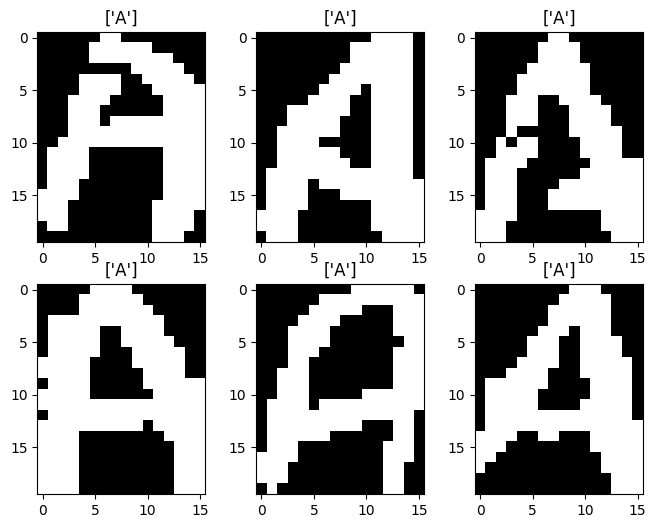

In [86]:
## visualize the first 6 A
fig, ax = plt.subplots(2,3, figsize=(8,6))
for i in range(6):
    ax[i//3, i%3].imshow(data_alphadigits['dat'][10][i].reshape(20,16), cmap='gray')
    ax[i//3, i%3].set_title(data_alphadigits['classlabels'][10])
plt.show()

#### 1.2- MNIST dataset

In [87]:
##We load MNIST dataset from keras, so to have access to images and labels.
## We could not access the yann.lecun.com/exdb/mnist/ website, so we used the keras library to load the dataset.

In [88]:
## Uncomment below to load the mnist dataset from keras
# ! pip install keras

In [89]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test)  = mnist.load_data()

In [90]:
print(X_train.shape) ## (60000, 28, 28)
print(y_train.shape) ## (60000,)
print(X_test.shape) ## (10000, 28, 28)
print(y_test.shape) ## (10000,)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


#### 1.3- Vizualize a sample

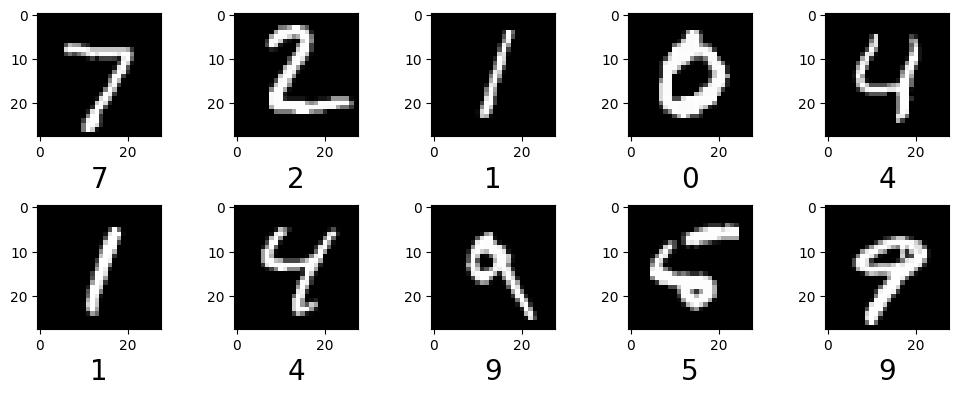

In [91]:
def plot_mnist(data, labels):
    fig, ax = plt.subplots(2,5)
    fig.set_size_inches(10, 4)
    for i, axi in enumerate(ax.flat):
        # plt.subplot(2, 5, i+1)
        axi.imshow(data[i], cmap='gray')
        axi.set_xlabel(labels[i], fontsize = 20)
    plt.tight_layout()
    plt.show()
plot_mnist(X_test, y_test)

### 2. Useful methods

#### 2.1- lire_alpha_digits()

In [92]:
# data_alphadigits['classlabels'].flatten().tolist()

In [93]:
## Retrieving all the labels/characters
char_list_all = []
for array in data_alphadigits['classlabels']:
    char_list_all.append(array[0])


In [94]:
def char_to_index(char):
    '''
    Convert a character to its corresponding index in the dataset
    '''
    assert char in char_list_all, "character not in the 36 digits categories"
    return char_list_all.index(char)

In [95]:
def lire_alpha_digit(data, char_list):
    X = []
    y = []
    char_list = np.unique([char.upper() for char in char_list])
    for char in char_list:
        for i in range(39):
            X.append(data['dat'][char_to_index(char)][i].reshape(1,-1))
        y.append(char)
    return np.concatenate(X), np.array(y) ## X.shape (39*n_chars, 320), y.shape (39*n_chars,)

In [96]:
### Test
set_ABC = lire_alpha_digit(data_alphadigits, ['a','C','B','c','b','A'])
print(set_ABC[0].shape, set_ABC[1]) 

(117, 320) ['A' 'B' 'C']


#### 2.2- Convert MNIST to Black & White

In [97]:
def convert_mnist_black_white(X, threshold = 127):
    '''
    Convert a 3D array of mnist images to 3D array of black and white images
    '''
    X_bw = []
    for i in range(X.shape[0]):
        X_bw.append(np.where(X[i] > threshold, 1, 0))
    return np.stack(X_bw, axis = 0)

In [98]:
X_train_bw = convert_mnist_black_white(X_train)
X_test_bw = convert_mnist_black_white(X_test)

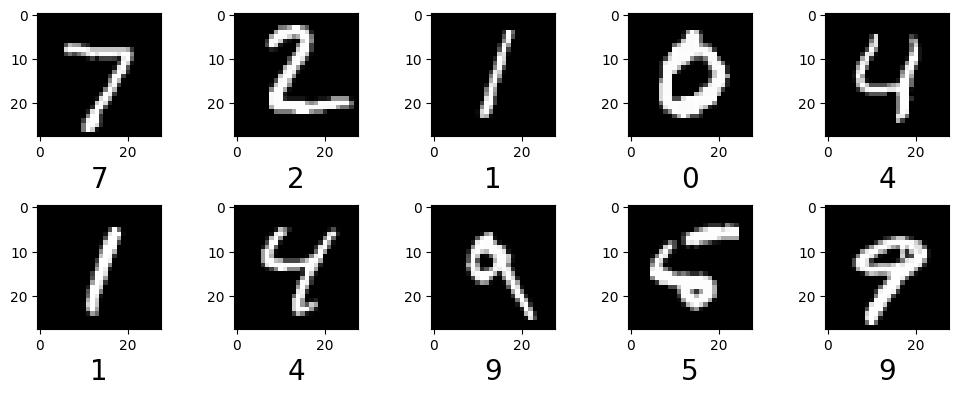

In [99]:
## Visualize the original greyscale images
plot_mnist(X_test[:10], y_test[:10])

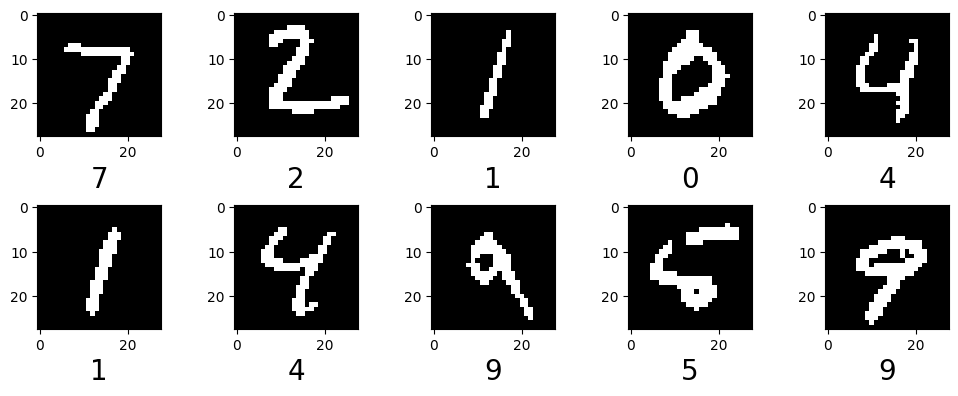

In [100]:
## And their black and white versions
plot_mnist(X_test_bw[:10], y_test[:10])

## 3. Restricted Boltzman Machine (RBM)

#### 3.1. RBM functions

In [208]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1/(1 + np.exp(-x))

In [144]:
def init_RBM(input_size, output_size):
    '''
    Initialize the parameters of the RBM
    '''
    a = np.zeros((1, input_size))
    b = np.zeros((1, output_size))
    W = np.random.normal(0, 0.01, (input_size, output_size))
    return [a, b, W]

In [209]:
def entree_sortie_RBM(RBM, V):
    '''
    Compute the output of the RBM
    V : input data, visible, shape (n_samples, input_size)
    '''
    _, b, W = RBM
    ## b : (1, output_size); W : (input_size, output_size)
    return sigmoid(np.dot(V, W) + b) ## shape (n_samples, output_size)

In [210]:
def sortie_entree_RBM(RBM, H):
    '''
    Compute the input of the RBM
    H : output data, hidden, shape (n_samples, output_size)
    '''
    a, _, W = RBM
    return sigmoid(np.dot(H, W.T) + a) ## shape (n_samples, input_size)

In [147]:
def train_RBM(RBM, input_data, n_epochs = 1, lr=1e-3, batch_size =8, verbose = True):
    '''
    Train the RBM
    '''
    a, b, W = RBM
    losses = []
    
    n_samples = input_data.shape[0] // batch_size * batch_size
    for epoch in tqdm(range(n_epochs)):
        current_loss = 0
        for i in range(0, n_samples, batch_size): ## drop_last = True
            V = input_data[i:i+batch_size].reshape(batch_size, -1) ## (B, input_size)
            H = entree_sortie_RBM(RBM, V) ## (B, output_size)
            V_prime = sortie_entree_RBM(RBM, H) ## (B, input_size)
            H_prime = entree_sortie_RBM(RBM, V_prime) ## (B, output_size)
            a += lr * (V - V_prime).mean(axis = 0)
            b += lr * (H - H_prime).mean(axis = 0)
            W += lr * (np.dot(V.T, H) - np.dot(V_prime.T, H_prime))
            current_loss += ((V - V_prime)**2).mean(axis = 1).sum()
        current_loss /= n_samples
        losses.append(current_loss)  
        if verbose:
            print('Epoch %d/%d' % (epoch+1, n_epochs))
            print('Loss : %.4f' % current_loss)
    return RBM, losses

In [148]:
def generer_image_RBM(trained_RBM, n_iter_gibbs = 10, n_samples=10):
    '''
    Generate images from the trained RBM
    '''
    V = np.random.binomial(1, 0.5, (n_samples, trained_RBM[0].shape[1])) ## initialize each component of V to bernoulli(0.5)
    #print(V)
    #plt.imshow(V[0].reshape(20,16), cmap='gray')
    for _ in range(n_iter_gibbs):
        
        # # This 
        # H = entree_sortie_RBM(trained_RBM, V)
        # V = sortie_entree_RBM(trained_RBM, H)
        
        ## or this
        H = np.random.binomial(1, entree_sortie_RBM(trained_RBM, V))
        V = np.random.binomial(1, sortie_entree_RBM(trained_RBM, H))
        
        # ## or this 
        # H = np.array([1 if value >= 0.5 else 0 for row in entree_sortie_RBM(trained_RBM, V) for value in row]).reshape(n_samples, -1)
        # V = np.array([1 if value >= 0.5 else 0 for row in sortie_entree_RBM(trained_RBM, H) for value in row]).reshape(n_samples, -1)
    # V = np.where(V > 0.5, 1, 0)
    #plt.imshow(V[0].reshape(20,16), cmap='gray')
    return V

In [149]:
## Plot the reconstruction loss
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction Loss')
    plt.title('Reconstruction Loss over epochs')
    plt.show()

#### 3.2. Testing everything

In [150]:
## Define a subset for training
train_set, _ = lire_alpha_digit(data_alphadigits, ['3'])
print(train_set.shape)
## Shuffle  the training set
train_set = train_set[np.random.permutation(train_set.shape[0])]

(39, 320)


In [151]:
## Initialize the RBM
RBM = init_RBM(320, 100)

In [152]:
## Train the RBM
_, losses = train_RBM(RBM, train_set, n_epochs = 200, lr=1e-2, batch_size =4, verbose = False)

100%|██████████| 200/200 [00:00<00:00, 502.02it/s]


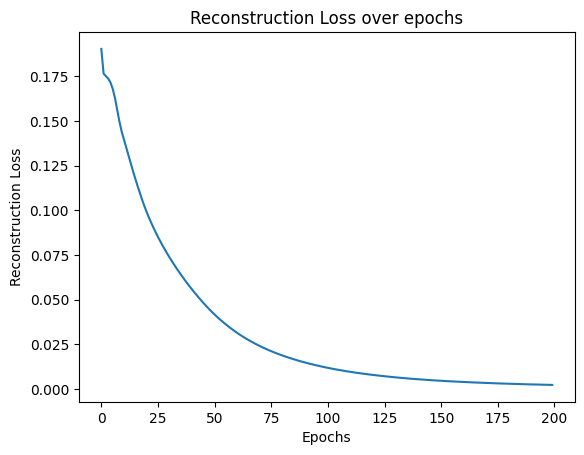

In [153]:
## Plot the loss
plot_loss(losses)

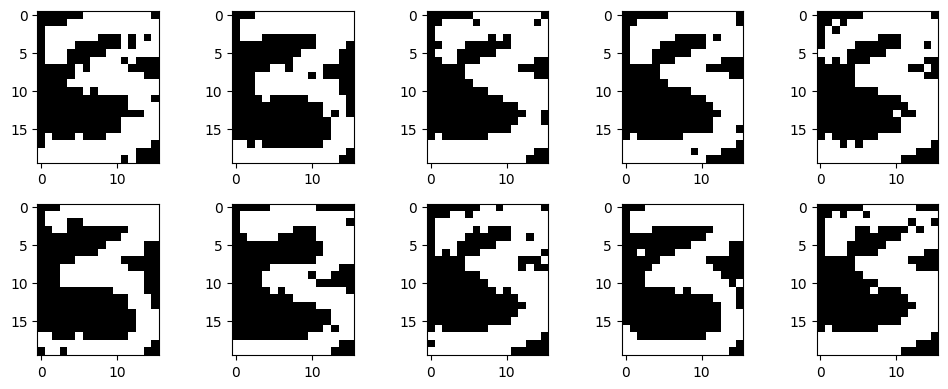

In [154]:
sampled_images = generer_image_RBM(RBM, n_iter_gibbs = 30, n_samples=10)

## Plot the sampled images
plot_mnist(sampled_images.reshape(-1,20,16)[:10], np.array(['']*10))

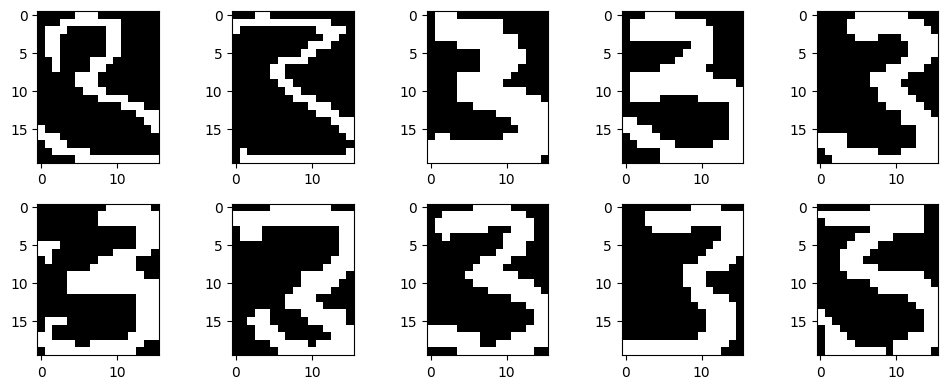

In [155]:
## Plot true images from the training set
plot_mnist(train_set[:10].reshape(-1,20,16), np.array(['']*10))

## 4. Deep Belief Networks (DBN)

In [156]:
## init_DBN
def init_DBN(num_layers, input_size, hidden_size):
    '''
    Initialize the parameters of the DBN
    '''
    DBN = []
    for i in range(num_layers):
        if i == 0:
            DBN.append(init_RBM(input_size, hidden_size))
        else:
            DBN.append(init_RBM(hidden_size, hidden_size))
    return DBN

In [157]:
def train_DBN(DBN, input_data, n_epochs = 1, lr=1e-3, batch_size =8, verbose = True):
    '''
    Train the DBN using the greedy layer-wise strategy
    '''
    losses = []
    for i, RBM in enumerate(DBN):
        print('Training RBM %d/%d' % (i+1, len(DBN)))
        RBM, loss = train_RBM(RBM, input_data, n_epochs, lr, batch_size, verbose)
        input_data = entree_sortie_RBM(RBM, input_data)
        losses.append(loss)
    losses = np.stack(losses, axis = 0)
    return DBN, losses

In [159]:
## Test on the alpha digits dataset
DBN = init_DBN(5, 320, 64)
trained_DBN, losses_DBN = train_DBN(DBN, train_set, n_epochs = 100, lr=1e-2, batch_size =4, verbose = False)


Training RBM 1/5


100%|██████████| 100/100 [00:00<00:00, 628.04it/s]


Training RBM 2/5


100%|██████████| 100/100 [00:00<00:00, 974.48it/s]


Training RBM 3/5


100%|██████████| 100/100 [00:00<00:00, 1260.89it/s]


Training RBM 4/5


100%|██████████| 100/100 [00:00<00:00, 1271.60it/s]


Training RBM 5/5


100%|██████████| 100/100 [00:00<00:00, 1265.31it/s]


In [160]:
## Plot the loss curves of the DBN on the same plot
def plot_loss_DBN(losses_DBN):
    for i, loss in enumerate(losses_DBN):
        plt.plot(loss, label = 'RBM %d' % (i+1))
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction Loss')
    plt.title('Reconstruction Loss over epochs')
    plt.legend()
    plt.show()

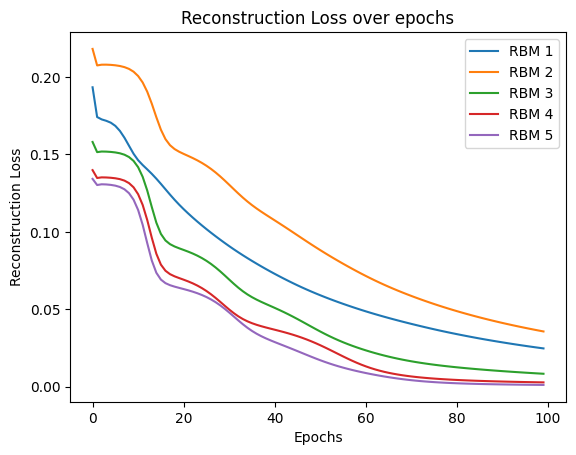

In [161]:
plot_loss_DBN(losses_DBN)

In [162]:
## print the model
for i, RBM in enumerate(trained_DBN):
    print('RBM %d' % (i+1))
    print(RBM[0].shape, RBM[1].shape, RBM[2].shape)

RBM 1
(1, 320) (1, 64) (320, 64)
RBM 2
(1, 64) (1, 64) (64, 64)
RBM 3
(1, 64) (1, 64) (64, 64)
RBM 4
(1, 64) (1, 64) (64, 64)
RBM 5
(1, 64) (1, 64) (64, 64)


In [119]:
# ## Visualize the loss in the DBN
# for i, loss in enumerate(losses_DBN):
#     print('RBM %d' % (i+1))
#     plot_loss(loss)
    

In [163]:
## Generate images from the trained DBN using Gibbs sampling
def generer_image_DBN(n_iter_gibbs = 10, n_samples=10, trained_DBN = trained_DBN):
    '''
    Generate images from the trained DBN
    '''
    L = len(trained_DBN) ## number of layers
    ## We first sample from the last layer
    V = np.random.binomial(1, 0.5, (n_samples, trained_DBN[L-1][0].shape[1])) 
    for _ in range(n_iter_gibbs):
        H = entree_sortie_RBM(trained_DBN[L-1], V)
        # H = np.random.binomial(1, H)
        V = sortie_entree_RBM(trained_DBN[L-1], H)
        # V = np.random.binomial(1, V)
    for l in range(L-2, -1, -1):
        V = sortie_entree_RBM(trained_DBN[l], V)
    
    # V = np.random.binomial(1, V) ## (n_samples, input_size)
    V = np.where(V > 0.5, 1, 0)
    return V
            

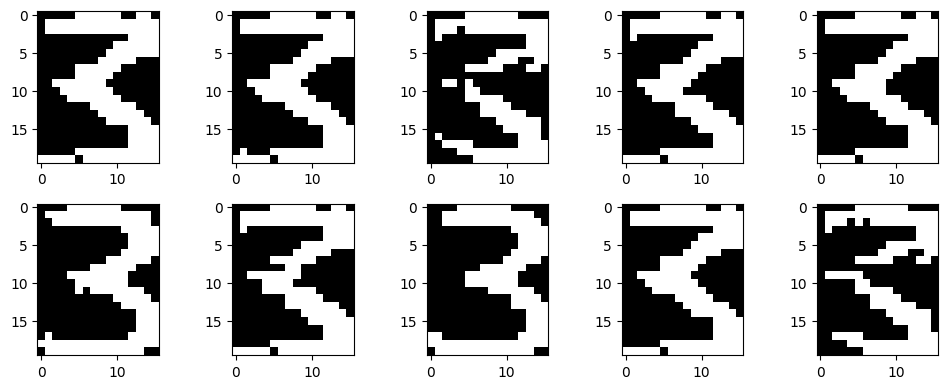

In [164]:
sampled_images_DBN = generer_image_DBN(n_iter_gibbs = 10, n_samples=10, trained_DBN = trained_DBN)
plot_mnist(sampled_images_DBN.reshape(-1,20,16)[:10], np.array(['']*10))

## 5. Deep Neural Networks (DNN)

In [165]:
### DNN implementation using DBN and classification head with softmax
def init_DNN(num_hidden_layers, input_size, hidden_size, output_size):
    '''
    Initialize the parameters of the DNN
    '''
    DNN = {}
    DNN['DBN'] = init_DBN(num_hidden_layers, input_size, hidden_size)
    ## Add the classification head
    DNN['head'] = init_RBM(hidden_size, output_size)
    
    return DNN

In [166]:
## Initialize the DNN for classification 
DNN = init_DNN(4, 320, 128, 36)


In [167]:
def pretrain_DNN(DNN, input_data, n_epochs = 1, lr=1e-3, batch_size =8, verbose = True):
    '''
    Pretrain the DBM module of the DNN using greedy layer-wise strategy
    We reuse the train_DBN function
    '''
    DNN['DBN'], _ = train_DBN(DNN['DBN'], input_data, n_epochs, lr, batch_size, verbose)
    
    return DNN
    
    

In [168]:
def calcul_softmax(RBM, X):
    '''
    Compute the class probabilities of X using the softmax function
    X : (n_samples, input_size)
    output : (n_samples, output_size)
    '''
    _, b, W = RBM
    out = np.exp(np.dot(X, W) + b)
    out = out / out.sum(axis = 1, keepdims = True)
    return out

In [169]:
def relu(x):
    return np.maximum(0, x)

In [187]:
def entree_sortie_reseau(DNN, input_data):
    '''
    Compute the output of the DNN at each layer and store them in a list
    '''
    L = len(DNN['DBN']) ## number of hidden layers
    outs = [input_data]
    for i in range(L):
        outs.append(entree_sortie_RBM(DNN['DBN'][i], outs[i]))
    outs.append(calcul_softmax(DNN['head'], outs[L]))
    return outs ## list of length L+1

In [198]:
def retropropagation(DNN, input_data, labels, n_epochs, lr, batch_size):
    '''
    Train the DNN using backpropagation
    '''
    losses = []
    num_layers = len(DNN['DBN'])
    n_samples = input_data.shape[0] // batch_size * batch_size
    for epoch in tqdm(range(n_epochs)):
        current_loss = 0
        for i in range(0, n_samples, batch_size): ## drop_last == True
            X = input_data[i:i+batch_size].reshape(batch_size, -1) ## (B, input_size)
            Y = labels[i:i+batch_size] ## (B,)
            ## Forward pass
            outs = entree_sortie_reseau(DNN, X) ## length L+2
            ## Compute the cross-entropy loss
            loss = -np.log(outs[-1][np.arange(batch_size), Y]).mean()
            current_loss += loss*batch_size
            
            ## BACKWARD PASS :
            
            ### Optimizer.zero_grad()
            dWs = []
            dbs = []
            dXs = []
            
            ###  loss.backward()
            ## gradient of the loss w.r.t the logits of the classification head
            dX = outs[-1] ## Y_pred : (B, output_size)
            dX[np.arange(batch_size), Y] -= 1 ## d_loss/d_ZL = Y_pred - Y : (B, output_size)
            dXs.append(dX) 

            ## gradient of the loss w.r.t the parameters and the input of the classification head
            dW = np.dot(outs[-2].T, dX) / batch_size
            dWs.append(dW)
            db = dX.mean(axis = 0)
            dbs.append(db)
            dX = np.dot(dX, DNN['head'][2].T)
            dXs.append(dX)
            ## The layers of the DBN
            for layer in range(len(DNN['DBN'])-1, -1, -1):
                dX = dXs[-1]
                dW = np.dot(outs[layer].T, dX) / batch_size
                db = dX.mean(axis = 0)
                dX = np.dot(dX, DNN['DBN'][layer][2].T)
                dXs.append(dX)
                dWs.append(dW)
                dbs.append(db)
            
            assert len(dWs) == len(dbs) == num_layers + 1, "The number of weights and biases gradients is incorrect"
            assert len(dXs) == num_layers + 2, "The number of inputs gradients is incorrect"
            
            ## Update the parameters. Optimizer.step()
            ## The layers of the DBN
            for layer in range(len(DNN['DBN'])):
                # print(layer)
                # print(DNN['DBN'][layer][2].shape, dWs[len(DNN['DBN']) - layer].shape)
                DNN['DBN'][layer][1] -= lr * dbs[len(DNN['DBN']) - layer]
                DNN['DBN'][layer][2] -= lr * dWs[len(DNN['DBN']) - layer]
            ## The classification head
            DNN['head'][1] -= lr * dbs[0]
            DNN['head'][2] -= lr * dWs[0]
            
        current_loss /= n_samples
        losses.append(current_loss)
        print('Epoch %d/%d' % (epoch+1, n_epochs))
        print('Loss : %.4f' % current_loss)
    return DNN, losses
            
            
            
            
            
            
            
            

In [172]:
## Testing the DNN on the MNIST dataset
indices = np.random.permutation(X_train_bw.shape[0])
X_train_bw = X_train_bw[indices]
y_train = y_train[indices]
X_train_bw = X_train_bw.reshape(X_train_bw.shape[0], -1)
X_test_bw = X_test_bw.reshape(X_test_bw.shape[0], -1)


In [314]:
DNN = init_DNN(2, 784, 64, 10)


In [315]:
DNN = pretrain_DNN(DNN, X_train_bw, n_epochs = 50, lr=1e-2, batch_size = 64, verbose = False)

Training RBM 1/2


100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Training RBM 2/2


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


In [316]:
## Generate images from the trained DNN using Gibbs sampling
sampled_images_DNN = generer_image_DBN(n_iter_gibbs = 10, n_samples=10, trained_DBN = DNN['DBN'])

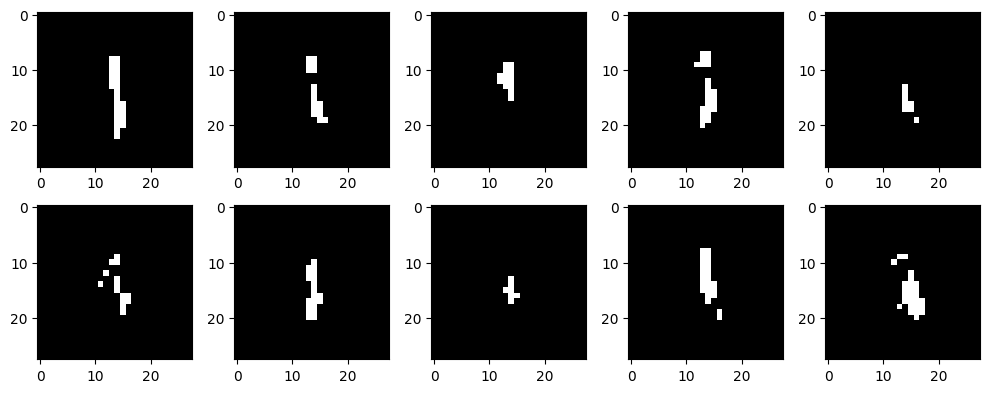

In [317]:
## Plot the sampled images
plot_mnist(sampled_images_DNN.reshape(-1,28,28)[:10], np.array(['']*10))

In [250]:
## testing on MNIST 
## Convert the labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)



In [318]:
DNN, losses_DNN = retropropagation(DNN, X_train_bw, y_train, n_epochs = 5, lr=1e-2, batch_size = 16)

 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

Epoch 1/5
Loss : 0.9255


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

Epoch 2/5
Loss : 0.5203


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

Epoch 3/5
Loss : 0.4663


 80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

Epoch 4/5
Loss : 0.4421


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

Epoch 5/5
Loss : 0.4335


In [285]:
## Accuracy on the test set
def accuracy_DNN(DNN, X, y):
    '''
    Compute the accuracy of the DNN on the test set
    '''
    y_pred = entree_sortie_reseau(DNN, X)[-1].argmax(axis = 1)
    return (y_pred == y).mean()


In [319]:
test_acc = accuracy_DNN(DNN, X_test_bw, y_test)
print('Test accuracy : %.4f' % test_acc)

Test accuracy : 0.8802


In [320]:
train_acc = accuracy_DNN(DNN, X_train_bw, y_train)
print('Train accuracy : %.4f' % train_acc)

Train accuracy : 0.8753


In [288]:
## Plot some images and their predictions
def plot_mnist_predictions(data, labels, predictions):
    fig, ax = plt.subplots(2,5)
    fig.set_size_inches(10, 4)
    for i, axi in enumerate(ax.flat):
        axi.imshow(data[i].reshape(28,28), cmap='gray')
        axi.set_xlabel('True : %d, Pred : %d' % (labels[i], predictions[i]), fontsize = 10)
    plt.tight_layout()
    plt.show()

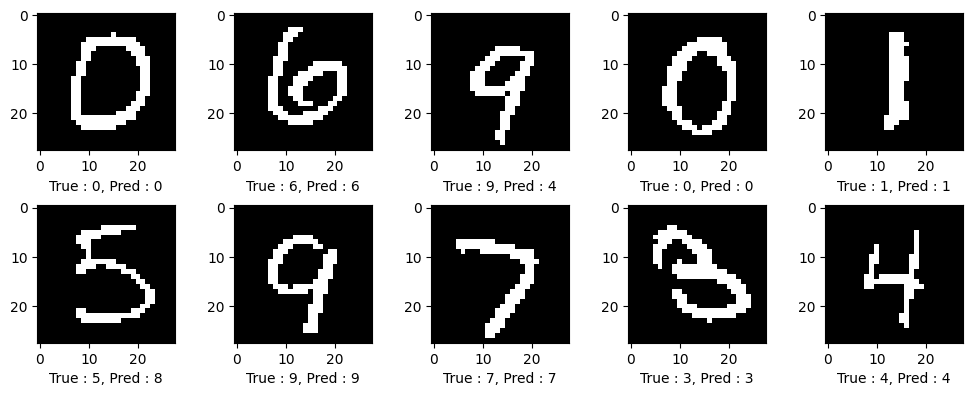

In [322]:
predictions = entree_sortie_reseau(DNN, X_test_bw)[-1].argmax(axis = 1)
plot_mnist_predictions(X_test_bw[10:20], y_test[10:20], predictions[10:20])
